# Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns
import zipfile
import sqlite3

# Opening data files, cleaning and assigning to dataframes so team is working from the same dataset

In [2]:
movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
print(movie_gross_data)

                                            title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year  


In [3]:
movie_popularity = pd.read_csv("zippedData/tmdb.movies.csv.gz")
print(movie_popularity)

       Unnamed: 0            genre_ids      id original_language  \
0               0      [12, 14, 10751]   12444                en   
1               1  [14, 12, 16, 10751]   10191                en   
2               2        [12, 28, 878]   10138                en   
3               3      [16, 35, 10751]     862                en   
4               4        [28, 878, 12]   27205                en   
...           ...                  ...     ...               ...   
26512       26512             [27, 18]  488143                en   
26513       26513             [18, 53]  485975                en   
26514       26514         [14, 28, 12]  381231                en   
26515       26515      [10751, 12, 28]  366854                en   
26516       26516             [53, 27]  309885                en   

                                     original_title  popularity release_date  \
0      Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19   
1                      

In [4]:
#cleaning 
movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
movie_gross_data["foreign_gross"].fillna(0, inplace = True)
movie_gross_data["domestic_gross"].fillna(0, inplace = True)
movie_gross_data.dropna(inplace = True)
print(movie_gross_data)

                                            title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year  


In [5]:
#cleaning 
movie_gross_data["domestic_gross"].replace(',','', regex = True, inplace = True)
movie_gross_data["foreign_gross"].replace(',','', regex = True, inplace = True)

In [6]:
movie_gross_data["total_gross"] = movie_gross_data["foreign_gross"].astype(float) + movie_gross_data["domestic_gross"].astype(float)
print(movie_gross_data)

                                            title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year   

Using zipfile to unzip imdb database and creating connection to the database

In [7]:
with zipfile.ZipFile("zippedData/im.db.zip", "r") as zObject:
        zObject.extractall()

In [8]:
conn = sqlite3.connect("im.db")
cur = conn.cursor()

Ensuring database is pulling correctly by running simple queries, analyzing columns to see where movie_basics and movie_ratings tables join

In [9]:
pd.read_sql("""
SELECT *
FROM movie_basics
GROUP BY genres
;
""", conn).head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0187902,How Huang Fei-hong Rescued the Orphan from the...,How Huang Fei-hong Rescued the Orphan from the...,2011,NaN,None
1,tt0364201,Aman Ke Farishtey,Aman Ke Farishtey,2016,137.0,Action
2,tt6848590,Moonshine Meat Market Mayhem,Moonshine Meat Market Mayhem,2016,NaN,"Action,Adult,Comedy"
3,tt10097958,Gripped: Climbing Killer Pillar,Gripped: Climbing Killer Pillar,2019,NaN,"Action,Adventure"
4,tt0448694,Puss in Boots,Puss in Boots,2011,90.0,"Action,Adventure,Animation"


In [10]:
pd.read_sql("""
SELECT *
FROM movie_ratings
;
""", conn).head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


# Question: What movies are doing well at the box office by genre and ratings? 

Below is the query I ran to find join the movie_ratings and movie_basics tables from the imdb database to pull genres and movie ratings. I wanted to pull genres with a rating of 8.4 or higher and to exclude those rows that have a null value for genre. I wanted the results in descendingorder so I have ratings of 10 at the top. I then made the query into a dataframe so I can graph it and group the genres so I have a more concise and accurate dataset.

In [47]:
q = """
SELECT averagerating as avg_rating, genres
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
WHERE averagerating >= 8.5
AND numvotes > 30
AND genres IS NOT NULL
ORDER BY avg_rating DESC
;
"""
high_ratings = pd.read_sql(q, conn)
print(high_ratings)

      avg_rating                       genres
0            9.9                        Drama
1            9.8            Documentary,Music
2            9.7                  Documentary
3            9.7                  Documentary
4            9.7                  Documentary
...          ...                          ...
1052         8.5                        Drama
1053         8.5      Action,Adventure,Sci-Fi
1054         8.5  Biography,Documentary,Music
1055         8.5                        Drama
1056         8.5                  Documentary

[1057 rows x 2 columns]


In [68]:
high_ratings = high_ratings[high_ratings["genres"].str.contains("None") == False]

data_for_analysis_by_rating = high_ratings.groupby(by="genres", as_index=False).mean()

data_for_analysis_by_rating_sort = data_for_analysis_by_rating.sort_values(by = 'avg_rating', ascending=False)

print(data_for_analysis_by_rating_sort)

                         genres  avg_rating
79         Comedy,Drama,Musical         9.5
12    Action,Comedy,Documentary         9.4
119   Documentary,History,Sport         9.4
44             Adventure,Family         9.4
102      Crime,Mystery,Thriller         9.3
..                          ...         ...
137       Drama,Fantasy,Musical         8.5
147        Drama,Mystery,Sci-Fi         8.5
16         Action,Crime,Mystery         8.5
110     Documentary,Drama,Sport         8.5
45   Adventure,Mystery,Thriller         8.5

[171 rows x 2 columns]


Pulling top 30 rows from the dataframe as these are the most relevant to helping support my original question 

In [74]:
top_30 = data_for_analysis_by_rating_sort.iloc[:30]

print(top_30)

                            genres  avg_rating
79            Comedy,Drama,Musical    9.500000
12       Action,Comedy,Documentary    9.400000
119      Documentary,History,Sport    9.400000
44                Adventure,Family    9.400000
102         Crime,Mystery,Thriller    9.300000
8     Action,Biography,Documentary    9.300000
46                 Adventure,Sport    9.200000
19       Action,Documentary,Family    9.200000
39   Adventure,Documentary,Western    9.200000
77            Comedy,Drama,Fantasy    9.200000
92                   Comedy,Sci-Fi    9.200000
74      Comedy,Documentary,History    9.200000
163                Mystery,Romance    9.200000
138                  Drama,History    9.150000
124          Documentary,Music,War    9.150000
108        Documentary,Drama,Music    9.133333
93                    Comedy,Sport    9.100000
123        Documentary,Music,Sport    9.100000
40                 Adventure,Drama    9.100000
140           Drama,Horror,Mystery    9.100000
112          

# Visualization to learn more about the data and form recommendation

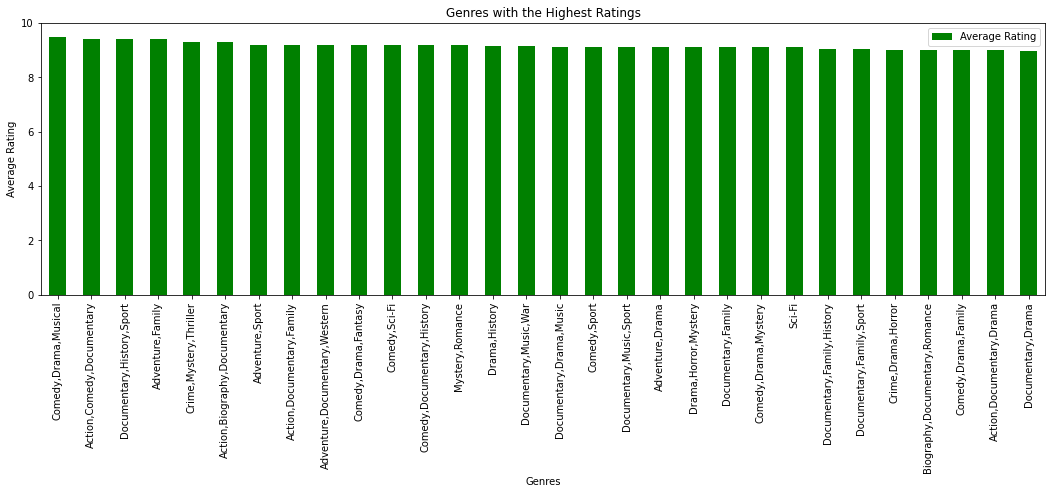

In [75]:
#plt.figure(figsize=(18, 5))
#plt.bar(top_30["genres"], top_30["avg_rating"], color = "b")

top_30.plot("genres", kind="bar", figsize = (18,5), color = "g")
plt.xlabel("Genres")
plt.xticks(rotation = 90)
plt.ylabel("Average Rating")
plt.yticks(range(0,11,2))
plt.title("Genres with the Highest Ratings")
plt.legend(labels=['Average Rating'])
plt.show()

# Information about genres with the lowest ratings to help support our recommendation

In [62]:
q2 = """
SELECT averagerating as avg_rating, genres
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
WHERE averagerating <= 2
AND numvotes > 30
AND genres IS NOT NULL
GROUP BY genres
ORDER BY avg_rating DESC
;
"""
low_ratings = pd.read_sql(q2, conn)
print(low_ratings)

     avg_rating                      genres
0           2.0                     Western
1           2.0             Sci-Fi,Thriller
2           2.0       Drama,Mystery,Romance
3           2.0                       Crime
4           2.0      Comedy,Musical,Romance
..          ...                         ...
98          1.0               Drama,Romance
99          1.0                Drama,Family
100         1.0                       Drama
101         1.0  Adventure,Biography,Comedy
102         1.0  Adventure,Animation,Family

[103 rows x 2 columns]


In [69]:
low_ratings = low_ratings[low_ratings["genres"].str.contains("None") == False]

data_for_analysis_by_rating_low = low_ratings.groupby(by="genres", as_index=False).mean()

data_for_analysis_by_rating_sort_low = data_for_analysis_by_rating_low.sort_values(by = 'avg_rating', ascending=True)

print(data_for_analysis_by_rating_sort_low)

                      genres  avg_rating
86   Fantasy,Mystery,Romance         1.0
78             Drama,Romance         1.0
72              Drama,Family         1.0
71                     Drama         1.0
82                    Family         1.0
..                       ...         ...
57            Comedy,Fantasy         2.0
61    Comedy,Musical,Romance         2.0
64                     Crime         2.0
100          Sci-Fi,Thriller         2.0
102                  Western         2.0

[103 rows x 2 columns]


In [70]:
#fix for pulling lowest 30 not starting at 2
top_30_low = data_for_analysis_by_rating_sort_low.iloc[:30]

print(top_30_low)

                        genres  avg_rating
86     Fantasy,Mystery,Romance         1.0
78               Drama,Romance         1.0
72                Drama,Family         1.0
71                       Drama         1.0
82                      Family         1.0
35  Adventure,Animation,Family         1.0
36  Adventure,Biography,Comedy         1.0
94                       Music         1.1
29           Action,Sci-Fi,War         1.1
38     Adventure,Drama,Romance         1.1
97                     Romance         1.1
59       Comedy,History,Horror         1.1
63               Comedy,Sci-Fi         1.1
67              Crime,Thriller         1.1
24       Action,Fantasy,Sci-Fi         1.2
27               Action,Sci-Fi         1.2
42     Animation,Comedy,Family         1.2
51         Comedy,Drama,Family         1.2
80              Drama,Thriller         1.2
16         Action,Crime,Horror         1.2
40          Adventure,Thriller         1.3
81                   Drama,War         1.3
18         

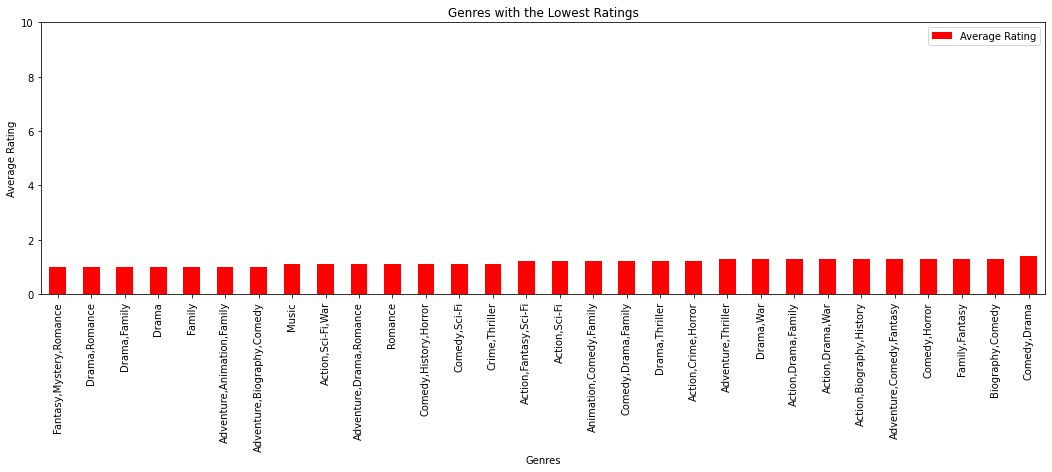

In [71]:
#plt.figure(figsize=(18, 5))
#plt.bar(top_30["genres"], top_30["avg_rating"], color = "b")

top_30_low.plot("genres", kind="bar", figsize = (18,5), color = "r")
plt.xlabel("Genres")
plt.xticks(rotation = 90)
plt.ylabel("Average Rating")
plt.yticks(range(0,11,2))
plt.title("Genres with the Lowest Ratings")
plt.legend(labels=['Average Rating'])
plt.show()